In [49]:
from glob import glob
import pandas as pd
import os
import math
from tqdm import tqdm
import seaborn as sns

PYRAD_PROFILE_DIR = "/home/christer/Datasets/MCF7_paper/structured/profiles/pyradiomics/gaussian_3"
DINO_PROFILE_DIR = "/home/christer/Datasets/MCF7_paper/structured/profiles/dino/gaussian_3"
METADATA_PATH = "/home/christer/Datasets/MCF7_paper/metadata/filtered_metadata.csv"

In [25]:
metadata = pd.read_csv(METADATA_PATH)
metadata

,Unnamed: 0,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
0,0,2,113,Week2_180607_D10_s1_w13459A84F-B9BB-4FB2-B58E-...,Week2/Week2_24121,Week2_180607_D10_s1_w2D35FB8FC-0085-4F4D-B14A-...,Week2/Week2_24121,Week2_180607_D10_s1_w440EA0925-FF71-447F-B395-...,Week2/Week2_24121,Week2_24121,D10,1,ALLN,0.03
1,1,2,114,Week2_180607_D10_s2_w111F1FA1E-8B45-451D-9C50-...,Week2/Week2_24121,Week2_180607_D10_s2_w277BE8611-E2E6-456E-838C-...,Week2/Week2_24121,Week2_180607_D10_s2_w433B4BF8D-9087-401F-89B1-...,Week2/Week2_24121,Week2_24121,D10,1,ALLN,0.03
2,2,2,115,Week2_180607_D10_s3_w13C4CF98E-5824-43A6-A319-...,Week2/Week2_24121,Week2_180607_D10_s3_w2D8C8A48C-6EAF-463F-A673-...,Week2/Week2_24121,Week2_180607_D10_s3_w4E03CCDE6-86D5-4F10-9B54-...,Week2/Week2_24121,Week2_24121,D10,1,ALLN,0.03
3,3,2,116,Week2_180607_D10_s4_w1E4144E18-06FF-4789-8F9F-...,Week2/Week2_24121,Week2_180607_D10_s4_w25BD84D0B-672D-4292-87B7-...,Week2/Week2_24121,Week2_180607_D10_s4_w4A0FA5EEA-D0F6-4857-9C81-...,Week2/Week2_24121,Week2_24121,D10,1,ALLN,0.03
4,4,2,353,Week2_180607_D10_s1_w199106068-CEA7-4BAB-83EA-...,Week2/Week2_24141,Week2_180607_D10_s1_w20787BC73-DFAE-40D7-80BA-...,Week2/Week2_24141,Week2_180607_D10_s1_w4E09AB7C1-BAF1-4FFE-BFC7-...,Week2/Week2_24141,Week2_24141,D10,2,ALLN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6155,6155,9,3560,Week9_090907_F11_s4_w19580FF4D-DC3D-4BD0-93FE-...,Week9/Week9_39301,Week9_090907_F11_s4_w2DC65EC6F-BDCA-4B05-B243-...,Week9/Week9_39301,Week9_090907_F11_s4_w45699A0F4-9AEE-4CD4-8973-...,Week9/Week9_39301,Week9_39301,F11,3,DMSO,0.00
6156,6156,9,3597,Week9_090907_G11_s1_w1EDE534D2-FCEE-4F92-A30B-...,Week9/Week9_39301,Week9_090907_G11_s1_w26A22E27F-6A81-43F5-9587-...,Week9/Week9_39301,Week9_090907_G11_s1_w4554A2BF7-0D53-4D27-BF92-...,Week9/Week9_39301,Week9_39301,G11,3,DMSO,0.00
6157,6157,9,3598,Week9_090907_G11_s2_w10B010F39-3B4B-4DCB-8E34-...,Week9/Week9_39301,Week9_090907_G11_s2_w2720AC778-3F85-4293-8D75-...,Week9/Week9_39301,Week9_090907_G11_s2_w49B290958-BCF2-4DDD-B0E9-...,Week9/Week9_39301,Week9_39301,G11,3,DMSO,0.00
6158,6158,9,3599,Week9_090907_G11_s3_w10394282C-6D3D-4E0E-9FA3-...,Week9/Week9_39301,Week9_090907_G11_s3_w24C59DB62-E99B-4284-BAD2-...,Week9/Week9_39301,Week9_090907_G11_s3_w471FE25C8-2477-456F-9D74-...,Week9/Week9_39301,Week9_39301,G11,3,DMSO,0.00


In [44]:
compounds = metadata["Image_Metadata_Compound"].unique().tolist()

distances = []
count_missing_ctrl = 0
count_missing_drug = 0


for compound in tqdm(compounds):
    if compound == "DMSO":
        continue
    doses = metadata[metadata["Image_Metadata_Compound"] == compound]["Image_Metadata_Concentration"].unique().tolist()
    for dose in doses:
        df_dose_compound = metadata[(metadata["Image_Metadata_Compound"] == compound) & (metadata["Image_Metadata_Concentration"] == dose)]
        for idx_row, row in df_dose_compound.iterrows():
            profile_path = row["Image_PathName_DAPI"].split("/")[1] + "/" + row["Image_FileName_DAPI"][:-4] + ".csv"
            
            pyrad_path = os.path.join(PYRAD_PROFILE_DIR, profile_path)
            dino_path = os.path.join(DINO_PROFILE_DIR, profile_path)
            
            if not os.path.exists(pyrad_path) or not os.path.exists(dino_path):
                count_missing_drug += 1
                continue
            
            pyrad_profile = pd.read_csv(pyrad_path)
            dino_profile = pd.read_csv(dino_path)
            
            pyrad_profile_filtered = pyrad_profile.mean().to_frame().T
            dino_profile_filtered = dino_profile.mean().to_frame().T
            
            joint_profile = pd.concat([dino_profile_filtered, pyrad_profile_filtered], axis=1).drop(columns=["Unnamed: 0", "id"])
            
            controls = metadata[(row["Image_Metadata_Plate_DAPI"] == metadata["Image_Metadata_Plate_DAPI"]) & 
                               (metadata["Image_Metadata_Compound"] == "DMSO")]
            
            control_profiles = []
            for idx_ctrl, ctrl_row in controls.iterrows():
                ctrl_profile_path = ctrl_row["Image_PathName_DAPI"].split("/")[1] + "/" + ctrl_row["Image_FileName_DAPI"][:-4] + ".csv"
                
                ctrl_pyrad_path = os.path.join(PYRAD_PROFILE_DIR, profile_path)
                ctrl_dino_path = os.path.join(DINO_PROFILE_DIR, profile_path)
            
                if not os.path.exists(ctrl_pyrad_path) or not os.path.exists(ctrl_dino_path):
                    count_missing_ctrl += 1
                    continue
                    
                ctrl_pyrad_profile = pd.read_csv(ctrl_pyrad_path)
                ctrl_dino_profile = pd.read_csv(ctrl_dino_path)

                pyrad_ctrl_profile_filtered = ctrl_pyrad_profile.mean().to_frame().T
                dino_ctrl_profile_filtered = ctrl_dino_profile.mean().to_frame().T
                joint_ctrl_profile = pd.concat([dino_ctrl_profile_filtered, pyrad_ctrl_profile_filtered], axis=1)
                control_profiles.append(joint_ctrl_profile)
            avg_control_profile = pd.concat(control_profiles).mean().to_frame().T.drop(columns=["Unnamed: 0", "id"])
            
            euc_distance = math.dist(avg_control_profile.values[0], joint_profile.values[0])
            distances.append([compound, dose, euc_distance])
df_distances = pd.DataFrame(distances, columns=["compound", "dose", "distance"])        

100%|██████████| 39/39 [41:06<00:00, 63.25s/it] 


<Axes: xlabel='dose', ylabel='distance'>

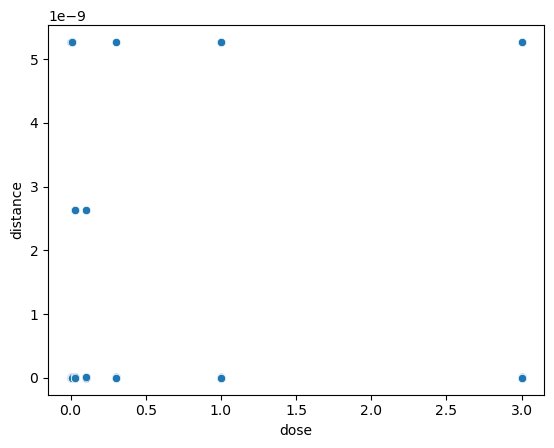

In [57]:
data = df_distances[df_distances["compound"] == "nocodazole"]
sns.scatterplot(data=data, x="dose", y="distance")

In [50]:
df_distances

,compound,dose,distance
0,ALLN,0.03,2.285232e-13
1,ALLN,0.03,2.311607e-13
2,ALLN,0.03,5.268356e-09
3,ALLN,0.03,5.268356e-09
4,ALLN,0.03,3.232835e-13
...,...,...,...
4819,AZ-U,10.00,2.873142e-14
4820,AZ-U,10.00,7.277184e-12
4821,AZ-U,10.00,5.034682e-14
4822,AZ-U,10.00,2.963280e-14
